# Preprocess STRING-db PPI Network
This notebook prepares the [STRING-db](https://string-db.org/) PPI network for use with graph convolutional networks.
I use version `v11.0`, downloaded from [here](https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz) and preprocessed in the following way:

* I remove scores > 0.85
* I map the IDs to have Hugo symbols and emsembl IDs using the mygene service

In [1]:
import pandas as pd
import mygene
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def get_gene_symbols_from_proteins(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.protein',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

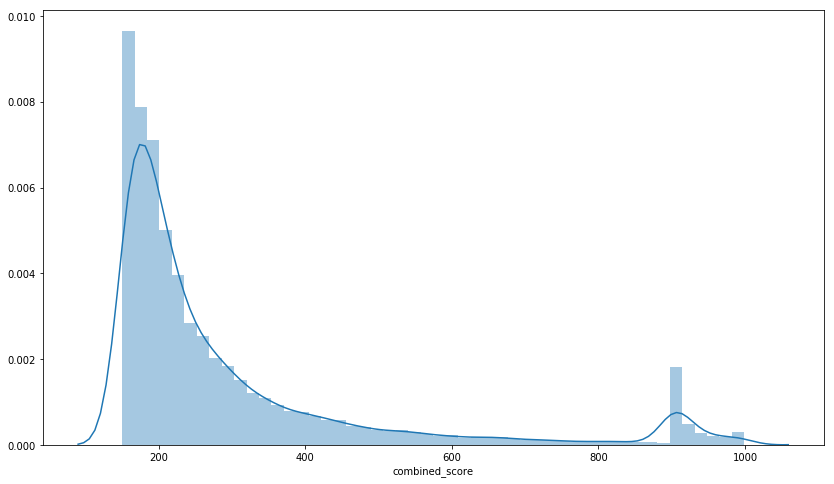

In [3]:
string_ppis = pd.read_csv('../data/networks/STRING_9606.protein.links.v11.0.txt', sep=' ')
fig = plt.figure(figsize=(14, 8))
sns.distplot(string_ppis.combined_score, kde_kws={'bw': 20})

In [4]:
high_conf_string_ppis = string_ppis[string_ppis.combined_score >= 850].copy() # same as 0.85 threshold (they multiplied by 1000 to have ints)
high_conf_string_ppis.loc[:, 'protein1'] = [i[1] for i in high_conf_string_ppis.protein1.str.split('.')]
high_conf_string_ppis.loc[:, 'protein2'] = [i[1] for i in high_conf_string_ppis.protein2.str.split('.')]
high_conf_string_ppis.to_csv('../data/networks/string_ENSP_ids_highconf.tsv', sep='\t', compression='gzip')

In [5]:
ens_names = high_conf_string_ppis.protein1.append(high_conf_string_ppis.protein2).unique()
ens_to_symbol = get_gene_symbols_from_proteins(ens_names)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13328...done.
Finished.
121 input query terms found no hit:
	['ENSP00000215939', 'ENSP00000222598', 'ENSP00000230732', 'ENSP00000266991', 'ENSP00000267012', 'ENS


In [6]:
p1_incl = high_conf_string_ppis.join(ens_to_symbol, on='protein1', how='inner', rsuffix='_p1')
both_incl = p1_incl.join(ens_to_symbol, on='protein2', how='inner', rsuffix='_p2')
string_edgelist_symbols = both_incl.drop(['protein1', 'protein2'], axis=1)
string_edgelist_symbols.columns = ['confidence', 'partner1', 'partner2']
string_ppi_final = string_edgelist_symbols[['partner1', 'partner2', 'confidence']]

In [7]:
G = nx.from_pandas_edgelist(string_ppi_final, source='partner1', target='partner2')
print ("Network with {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))

Network with 13179 nodes and 336551 edges


In [8]:
string_ppi_final.to_csv('../data/networks/string_SYMBOLS_highconf.tsv', sep='\t', compression='gzip')